In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar100
from tensorflow.keras import layers
from tensorflow.keras import layers
from keras.utils import np_utils, plot_model

# 1. Data Visualization & Preprocessing

In [2]:
num_classes = 100          # number of classes
num_super_classes = 20     # number of super-classes
input_shape = (32, 32, 3)  # original input image size

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


## 1.1. Data Visualization

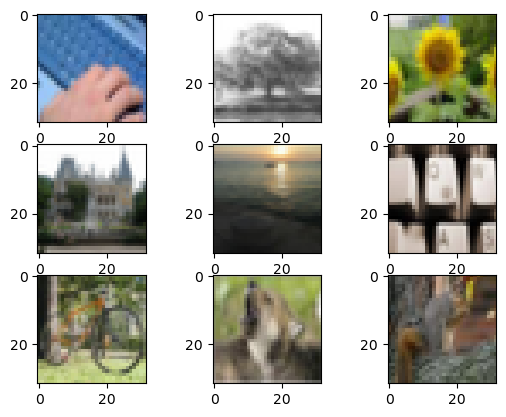

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Generate Superclasses

In [6]:
# download data from Keras API
(_, y_train_super), (_, y_test_super) = cifar100.load_data('coarse')

In [7]:
# check dataset size
print(f"X={X_train.shape}, y={y_train_super.shape}")
print(f"X={X_test.shape}, y={y_test_super.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


## 1.3. Data Processing

In [8]:
# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)


y_train shape:  (50000, 100)
y_test shape:  (10000, 100)

y_train_super shape:  (50000, 20)
y_test_super shape:  (10000, 20)


## 1.2. Data Augmentation

In [9]:
# set images parameters
image_size = 72                                # resize image from 32x32x3 to 72x72x3
patch_size = 6                                 # each image will be divided into patch with each patches has size of 6x6
num_patches = (image_size // patch_size) ** 2  # total number of patches in an image

In [10]:
print(f"The total number of patches in an splitted image is {num_patches}.")

The total number of patches in an splitted image is 144.


In [11]:
# create a data augmentation layer
data_aug = keras.Sequential(
    [
        layers.Normalization(),                  # normalize image
        layers.Resizing(image_size, image_size), # resize image from 32x32x3 to 72x72x3
    ],
    name="data_augmentation",
)

# compute the mean and varaince of the training data for normalization
data_aug.layers[0].adapt(X_train)

## 1.3. Patch Transformation
**Note**: Convert an input image into a patch-dimension. The class Patch's job is to transform image to patch-dimension. For instance, with our input image as **(1, 72, 72, 3)** = (1 image, 72 width pixel, 72 height pixel, 3 color channel), the output will be **(1, 12, 12, 108)** = (1 image, 12 width patch, 12 height patch, 108 depth).

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        """Constructor"""
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        """Forward-pass function"""
        batch_size = tf.shape(images)[0]
        
        # pixel to patch conversion
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        
        # get depth
        patch_dims = patches.shape[-1]
        
        # resize
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Note**: Let's go through an example

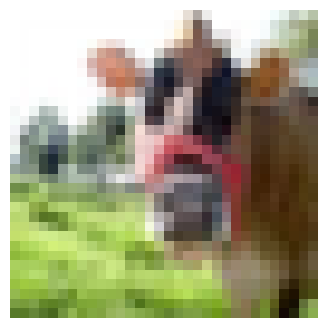

In [13]:
# plot original image
plt.figure(figsize=(4,4))
image = X_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

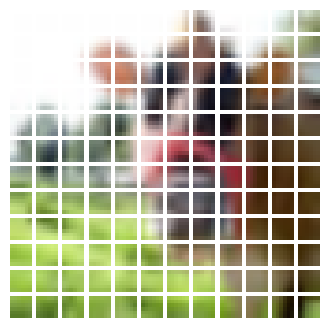

In [14]:
# resize and patch the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

# get number of patch width (or height)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

# patch the image and visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Note**: Let's get some calculated patches results after the transformation

In [15]:
print(f"Original image size: {image_size} x {image_size}.")
print(f"Calculated patch size: {patch_size} x {patch_size}.")
print(f"Number of patches per image: {patches.shape[1]}.")
print(f"Depth size of each patch: {patches.shape[-1]}.")

Original image size: 72 x 72.
Calculated patch size: 6 x 6.
Number of patches per image: 144.
Depth size of each patch: 108.


# 2. Modeling
**Note**: Build a Patch Encoding Layer and Build a Vision Transformers architecture.

In [16]:
# the size of the project dimension is just how depth the PatchEncoder layer prior to fetch to the Transformers
projection_dim = 64 

## 2.1. Patch Encoding Layer
**Note**: We will fetch each patch through a "Linear Projection of Flatten Patches" (aka, transform dimension via Dense layer) and attached the learnable Positional Embedding layer.

**Note**: Let's first visualize the positional embedding matrix. Each number is the position of each patch.

In [17]:
print(tf.range(start=0, limit=144, delta=1))

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143], shape=(144,), dtype=int32)


In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """Constructor"""
        super().__init__()
        self.num_patches = num_patches                       # (12 x 12) = 144 patches
        self.projection = layers.Dense(units=projection_dim) # Dense layer that map the patched input to the projection_dim
        self.position_embedding = layers.Embedding(          # learnable embedding layer for the position (above)
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        """Forward Pass"""
        # create a position matrix
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        # resize the input patch with Dense
        input_patch = self.projection(patch)
        
        # encode position array with learnable embedding layer
        pos_emb = self.position_embedding(positions)
        
        # patch + position embedding
        encoded_patch = input_patch + pos_emb
        
        return encoded_patch

## 2.2. Vision Transformers
**Note**: Input > Linear Projection > Stacked Encoder > MLP > Output Labels

In [19]:
# training settings
batch_size = 256          # number of images per batch
num_heads = 4             # nummber of attention heads in the multi-attention layer
num_epochs = 20           # number of training epochs
transformer_dropout = 0.2 # dropout rate of mlp inner of transformers
mlp_dropout = 0.2         # dropout rate of mlp outside of transformers

# transformers settings
transformer_layers = 8    # number of stacked encoder layers

In [20]:
def create_model(mlp_dropout):
    # set input layer
    inputs = layers.Input(shape=input_shape, name="input")

    # normalize and resize image
    augmented = data_aug(inputs)

    # convert image's pixels into patches
    patches = Patches(patch_size)(augmented)

    # encode patch by linearly transform patch with dense and add the learnable position encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # create stacked encoder
    for _ in range(transformer_layers):
        # layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # multi-head attention
        mtha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # skip connection 1 = add input with mtha
        x2 = layers.Add()([mtha, encoded_patches])

        # layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x4 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x4 = layers.Dropout(transformer_dropout)(x4)
        x4 = layers.Dense(projection_dim, activation=tf.nn.gelu)(x4)
        x4 = layers.Dropout(transformer_dropout)(x4)

        # skip connection 2
        encoded_patches = layers.Add()([x4, x2])

    # flatten transformers
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(mlp_dropout)(representation)
    features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    features = layers.Dropout(mlp_dropout)(features)
    
    # task 1 branch - fully connected for coarse-class classification
    task_1_branch = layers.Dense(1024, activation=tf.nn.gelu)(features)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(512, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(256, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(128, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(num_classes, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 2 branch - fully connected for fine-class classification
    task_2_branch = layers.Dense(512, activation=tf.nn.gelu)(features)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(256, activation=tf.nn.gelu)(task_2_branch)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(128, activation=tf.nn.gelu)(task_2_branch)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(num_super_classes, activation="softmax", name="task_2_output")(task_2_branch)
        
    # create model
    model = keras.Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

In [21]:
# create a model
model = create_model(mlp_dropout=mlp_dropout)

In [22]:
# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input[0][0]']                  
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

## 2.3. Compile Model

In [24]:
# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

## 2.4. Train & Validate Model

In [25]:
# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='./base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

In [26]:
# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
167/167 [==============================] - 97s 381ms/step - loss: 2.2413 - task_1_output_loss: 4.2692 - task_2_output_loss: 0.2135 - task_1_output_accuracy: 0.0537 - task_2_output_accuracy: 0.1368 - val_loss: 1.9940 - val_task_1_output_loss: 3.8225 - val_task_2_output_loss: 0.1655 - val_task_1_output_accuracy: 0.1032 - val_task_2_output_accuracy: 0.2740
Epoch 2/20
167/167 [==============================] - 62s 373ms/step - loss: 1.9712 - task_1_output_loss: 3.7708 - task_2_output_loss: 0.1716 - task_1_output_accuracy: 0.1151 - task_2_output_accuracy: 0.2538 - val_loss: 1.8358 - val_task_1_output_loss: 3.5180 - val_task_2_output_loss: 0.1535 - val_task_1_output_accuracy: 0.1588 - val_task_2_output_accuracy: 0.3280
Epoch 3/20
167/167 [==============================] - 64s 382ms/step - loss: 1.8221 - task_1_output_loss: 3.4874 - task_2_output_loss: 0.1568 - task_1_output_accuracy: 0.1622 - task_2_output_accuracy: 0.3263 - val_loss: 1.7404 - val_task_1_output_loss: 3.3341 - val_

In [27]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

Train loss: 0.38485410809516907
Train task 1 loss: 0.7319301962852478
Train task 2 loss: 0.037777919322252274
Train task 1 acc: 0.7875764966011047
Train task 2 acc: 0.8613176345825195


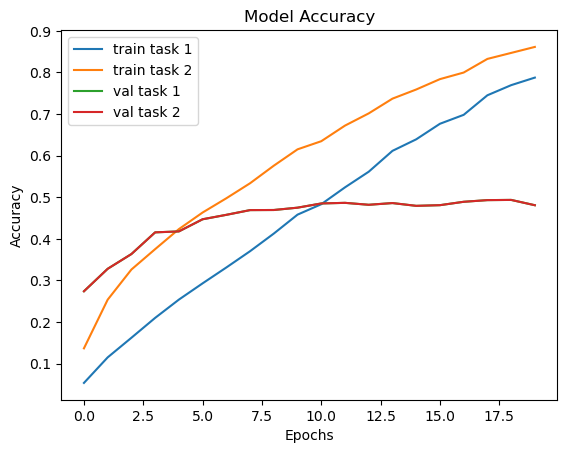

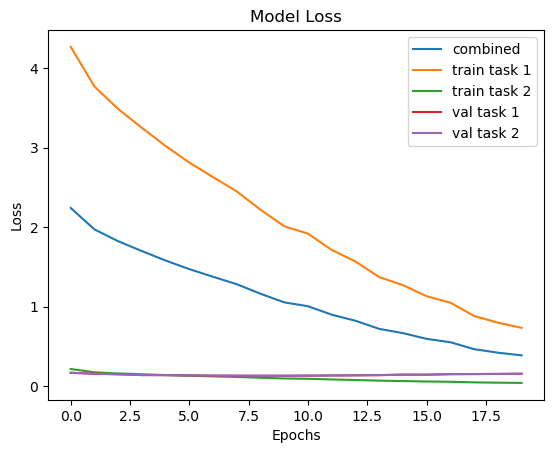

In [28]:
# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Test Trained Model

In [29]:
# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.923384189605713
Test task 1 loss: 3.6922574043273926
Test task 2 loss: 0.154510498046875
Test task 1 acc: 0.33469998836517334
Test task 2 acc: 0.4909999966621399


# 3. Optimize ViT with Different Parameters

## 3.1. Case 1  - Batch Size = 256, Dropout-MLP=0, Adam Optimizer (Trained Aboved)

In [30]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

Train loss: 0.38485410809516907
Train task 1 loss: 0.7319301962852478
Train task 2 loss: 0.037777919322252274
Train task 1 acc: 0.7875764966011047
Train task 2 acc: 0.8613176345825195


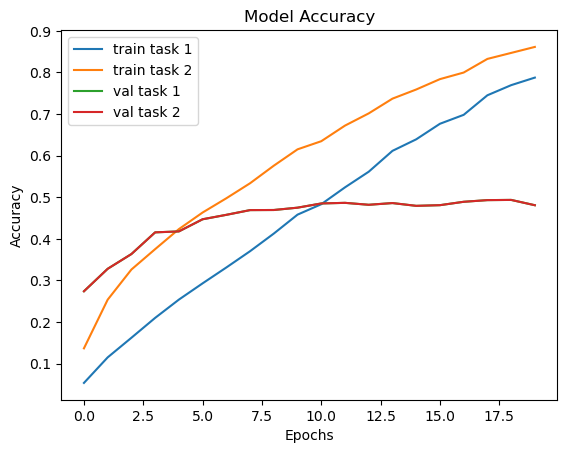

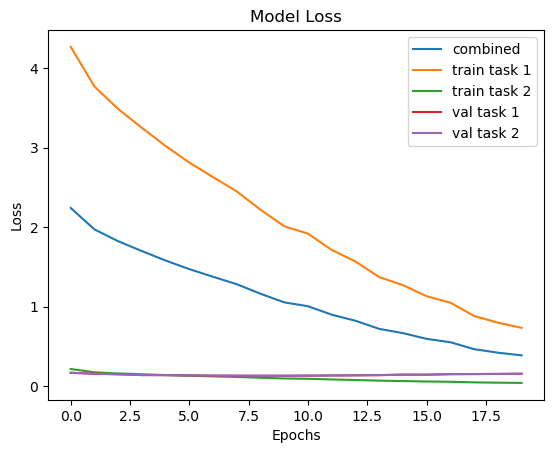

In [31]:
# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

In [32]:
# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.923384189605713
Test task 1 loss: 3.6922574043273926
Test task 2 loss: 0.154510498046875
Test task 1 acc: 0.33469998836517334
Test task 2 acc: 0.4909999966621399


## 3.2. Case 2  - Batch Size = 256, Gamma=0.4, Adam Optimizer

Epoch 1/20
167/167 [==============================] - 95s 393ms/step - loss: 1.8250 - task_1_output_loss: 4.2472 - task_2_output_loss: 0.2101 - task_1_output_accuracy: 0.0569 - task_2_output_accuracy: 0.1462 - val_loss: 1.6560 - val_task_1_output_loss: 3.8870 - val_task_2_output_loss: 0.1686 - val_task_1_output_accuracy: 0.1001 - val_task_2_output_accuracy: 0.2416
Epoch 2/20
167/167 [==============================] - 64s 382ms/step - loss: 1.6046 - task_1_output_loss: 3.7563 - task_2_output_loss: 0.1702 - task_1_output_accuracy: 0.1170 - task_2_output_accuracy: 0.2574 - val_loss: 1.5005 - val_task_1_output_loss: 3.5222 - val_task_2_output_loss: 0.1526 - val_task_1_output_accuracy: 0.1609 - val_task_2_output_accuracy: 0.3347
Epoch 3/20
167/167 [==============================] - 64s 382ms/step - loss: 1.4691 - task_1_output_loss: 3.4413 - task_2_output_loss: 0.1543 - task_1_output_accuracy: 0.1723 - task_2_output_accuracy: 0.3365 - val_loss: 1.4172 - val_task_1_output_loss: 3.3275 - val_

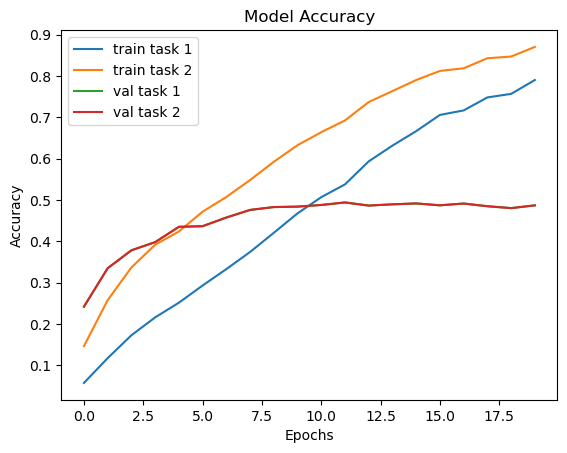

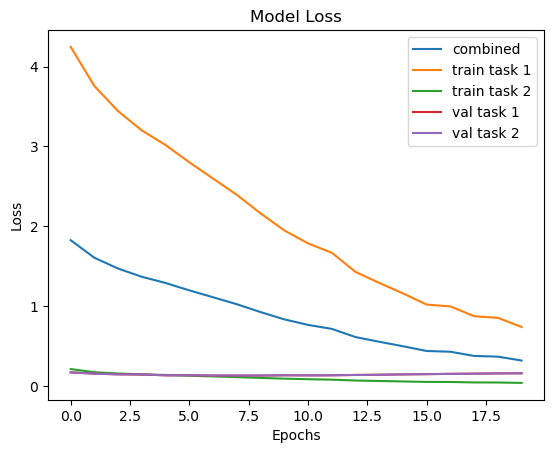

Test loss: 1.6117162704467773
Test task 1 loss: 3.786536693572998
Test task 2 loss: 0.16183573007583618
Test task 1 acc: 0.3303999900817871
Test task 2 acc: 0.47940000891685486


In [33]:
# training settings
batch_size = 256          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.4

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="./base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.3. Case 3  - Batch Size = 256, Gamma=0.6, Adam Optimizer

Epoch 1/20
167/167 [==============================] - 93s 383ms/step - loss: 2.6634 - task_1_output_loss: 4.2959 - task_2_output_loss: 0.2146 - task_1_output_accuracy: 0.0506 - task_2_output_accuracy: 0.1349 - val_loss: 2.3718 - val_task_1_output_loss: 3.8403 - val_task_2_output_loss: 0.1692 - val_task_1_output_accuracy: 0.1008 - val_task_2_output_accuracy: 0.2572
Epoch 2/20
167/167 [==============================] - 64s 382ms/step - loss: 2.3433 - task_1_output_loss: 3.7899 - task_2_output_loss: 0.1734 - task_1_output_accuracy: 0.1132 - task_2_output_accuracy: 0.2504 - val_loss: 2.1896 - val_task_1_output_loss: 3.5462 - val_task_2_output_loss: 0.1547 - val_task_1_output_accuracy: 0.1524 - val_task_2_output_accuracy: 0.3200
Epoch 3/20
167/167 [==============================] - 64s 382ms/step - loss: 2.1511 - task_1_output_loss: 3.4804 - task_2_output_loss: 0.1572 - task_1_output_accuracy: 0.1647 - task_2_output_accuracy: 0.3233 - val_loss: 2.0454 - val_task_1_output_loss: 3.3117 - val_

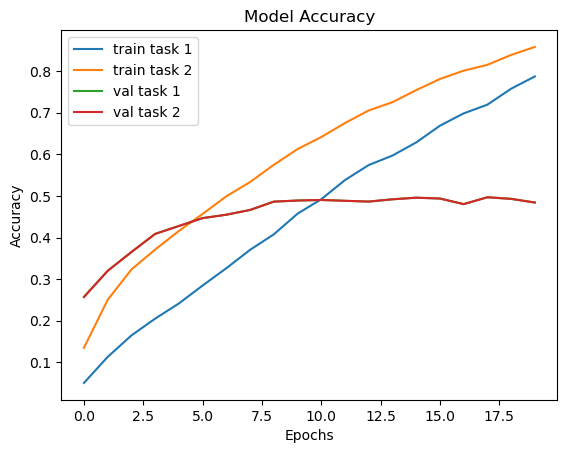

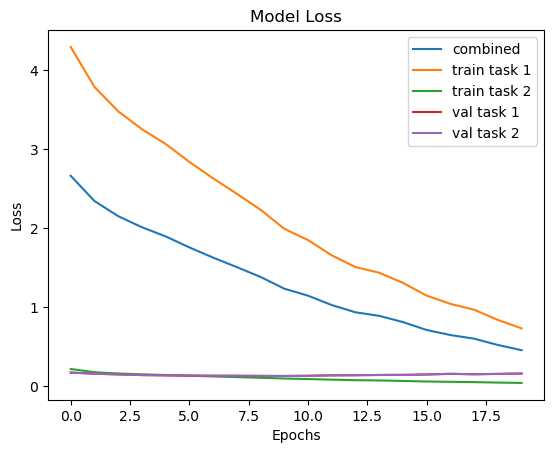

Test loss: 2.2625532150268555
Test task 1 loss: 3.666978597640991
Test task 2 loss: 0.15591225028038025
Test task 1 acc: 0.3336000144481659
Test task 2 acc: 0.4869999885559082


In [34]:
# training settings
batch_size = 256          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.6

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="./base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.4. Case 4  - Batch Size = 128, Gamma=0.5, Adam Optimizer

Epoch 1/20
333/333 [==============================] - 97s 208ms/step - loss: 2.2399 - task_1_output_loss: 4.2782 - task_2_output_loss: 0.2015 - task_1_output_accuracy: 0.0493 - task_2_output_accuracy: 0.1526 - val_loss: 1.9983 - val_task_1_output_loss: 3.8318 - val_task_2_output_loss: 0.1648 - val_task_1_output_accuracy: 0.1047 - val_task_2_output_accuracy: 0.2651
Epoch 2/20
333/333 [==============================] - 68s 203ms/step - loss: 1.9847 - task_1_output_loss: 3.8015 - task_2_output_loss: 0.1680 - task_1_output_accuracy: 0.1093 - task_2_output_accuracy: 0.2645 - val_loss: 1.8569 - val_task_1_output_loss: 3.5599 - val_task_2_output_loss: 0.1540 - val_task_1_output_accuracy: 0.1531 - val_task_2_output_accuracy: 0.3309
Epoch 3/20
333/333 [==============================] - 68s 203ms/step - loss: 1.8410 - task_1_output_loss: 3.5264 - task_2_output_loss: 0.1556 - task_1_output_accuracy: 0.1580 - task_2_output_accuracy: 0.3261 - val_loss: 1.7708 - val_task_1_output_loss: 3.3940 - val_

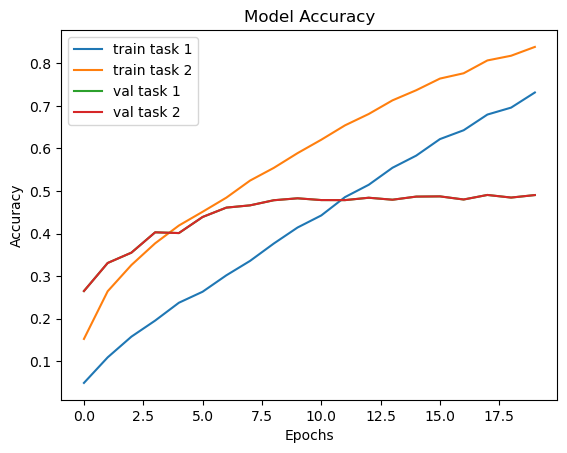

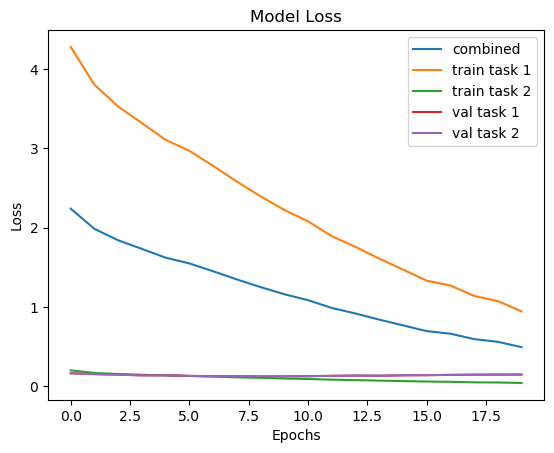

Test loss: 1.8092502355575562
Test task 1 loss: 3.4686195850372314
Test task 2 loss: 0.14988023042678833
Test task 1 acc: 0.3328000009059906
Test task 2 acc: 0.4876999855041504


In [35]:
# training settings
batch_size = 128          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="./base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.5. Case 5  - Batch Size = 128, Gamma=0.5, SGD Optimizer

Epoch 1/20
333/333 [==============================] - 84s 202ms/step - loss: 2.4949 - task_1_output_loss: 4.6318 - task_2_output_loss: 0.3580 - task_1_output_accuracy: 0.0123 - task_2_output_accuracy: 0.0524 - val_loss: 2.3757 - val_task_1_output_loss: 4.5502 - val_task_2_output_loss: 0.2013 - val_task_1_output_accuracy: 0.0395 - val_task_2_output_accuracy: 0.0717
Epoch 2/20
333/333 [==============================] - 65s 196ms/step - loss: 2.3996 - task_1_output_loss: 4.5637 - task_2_output_loss: 0.2355 - task_1_output_accuracy: 0.0208 - task_2_output_accuracy: 0.0592 - val_loss: 2.3377 - val_task_1_output_loss: 4.4795 - val_task_2_output_loss: 0.1959 - val_task_1_output_accuracy: 0.0535 - val_task_2_output_accuracy: 0.1047
Epoch 3/20
333/333 [==============================] - 67s 201ms/step - loss: 2.3634 - task_1_output_loss: 4.4993 - task_2_output_loss: 0.2274 - task_1_output_accuracy: 0.0318 - task_2_output_accuracy: 0.0663 - val_loss: 2.2826 - val_task_1_output_loss: 4.3722 - val_

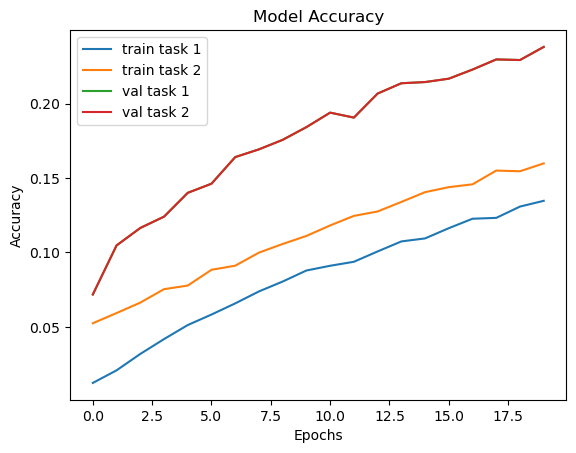

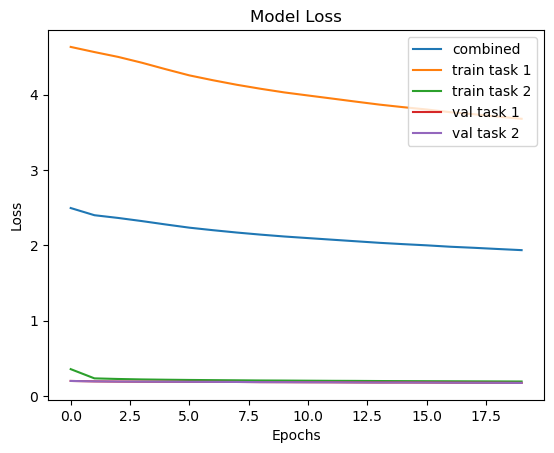

Test loss: 1.8293484449386597
Test task 1 loss: 3.483304738998413
Test task 2 loss: 0.1753918081521988
Test task 1 acc: 0.18070000410079956
Test task 2 acc: 0.23100000619888306


In [36]:
# training settings
batch_size = 128          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="./base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])